In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction import FeatureHasher
from datetime import datetime
tf.logging.set_verbosity(tf.logging.ERROR)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
class HR_Data_Prep_Utility(object):
	"""HR_Data_Prep_Utility is used for preparing data for the ML"""

	def __init__(self, dataset, feature_col, target_col, fe_hashing_ratio):
		"""
		Initialize and builds the HR Dataset to be used in training a model
		
		Only the below features are supported
		['MarriedID', 'MaritalStatusID', 'GenderID', 'EmpStatusID', 'DeptID', 'PerfScoreID', 'PayRate', 'Termd', 'PositionID', 'State', 'DOB', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'DateofHire', 'DateofTermination', 'ManagerName', 'RecruitmentSource', 'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 'LastPerformanceReview_Date']

		:param dataset: pandas dataframe read from csv
		:param feature_col: column names of the features
		:param target_col: column name of the target
		"""
		super(HR_Data_Prep_Utility, self).__init__()
		self.emp_ds = dataset
		self.feature_col = feature_col
		self.target_col = target_col
		self.fe_hashing_ratio = fe_hashing_ratio
		self._cat_col = ['MarriedID', 'MaritalStatusID', 'GenderID','EmpStatusID', 'DeptID', 'Termd', 'PositionID','State', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'ManagerName', 'RecruitmentSource']
		self._num_col = ['PayRate', 'PerfScoreID', 'Age', 'CurrentCmpyExp', 'EngagementSurvey', 'EmpSatisfaction','SpecialProjectsCount', 'DaysSinceLastRev']
		self._cat_col_onehot = ['MarriedID', 'MaritalStatusID', 'GenderID','EmpStatusID', 'Termd', 'CitizenDesc', 'HispanicLatino']
		self._cat_columns_feat_hash = ['DeptID', 'PositionID','State', 'RaceDesc', 'ManagerName', 'RecruitmentSource']


	def get_x_y_data(self):
		"""
		Description
		:param name: description
		:return: Description
		"""
		X, y = self._split_x_y(self.emp_ds)
		X = self._values_fix(X)
		X = self._add_features(X[self.feature_col])
		X = self._missing_values_fix(X)
		X = self._encode_category_features(X, reduction_ratio=self.fe_hashing_ratio)
		y = self._missing_values_fix(y)
		y = self._encode_category_features(y, reduction_ratio=self.fe_hashing_ratio)
		#X = self._scale_data(X)
		return X, y


	def _fe_fill_missing_val(self, X, column_name, fe_type):
		"""
		Description
		:param name: description
		:return: Description
		"""
		if(fe_type is 'num'):
			X[column_name + '_missing'] =  np.zeros((len(X.index), 1))
			#X.iloc[(X.loc[X[column_name].isna() == True]).index, X.columns.get_loc(column_name + '_missing')] = 1
			X.loc[X[column_name].isna() == True, column_name + '_missing'] = 1
			#X.iloc[(X.loc[X[column_name].isna() == True]).index, X.columns.get_loc(column_name)] = 0
			X.loc[X[column_name].isna() == True, column_name] = 0
		elif(fe_type is 'str'):
			#X.iloc[(X.loc[X[column_name].isna() == True]).index, X.columns.get_loc(column_name)] = 'Missing'
			X.loc[X[column_name].isna() == True, column_name] = 'Missing'
		return X


	def _fe_category_feature_hashing(self, X, column_name, n_features):
		"""
		Description
		:param name: description
		:return: Description
		"""
		fh = FeatureHasher(n_features=n_features, input_type='string')
		x_features_arr = fh.fit_transform(X[column_name].astype('str')).toarray()
		column_names = np.array([])
		for i in range(n_features):
			column_names = np.append(column_names, column_name+'_'+str(i+1))
		return pd.concat([X, pd.DataFrame(x_features_arr, columns=column_names)], axis=1)


	def _fe_category_one_hot_encoder(self, X, column_name):
		"""
		Description
		:param name: description
		:return: Description
		"""
		x_features_arr = pd.get_dummies(X[column_name])
		x_features_arr.rename(columns=lambda x: column_name+'_' + str(x), inplace=True)
		return pd.concat([X, x_features_arr], axis=1)


	def _split_x_y(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		return X[self.feature_col], X[self.target_col]


	def _add_features(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		now = datetime.now()
		if set(['DateofHire','DateofTermination']).issubset(X.columns):
			X['DateofHire'] = pd.to_datetime(X['DateofHire'], format="%m/%d/%Y")
			X['DateofTermination'] = pd.to_datetime(X['DateofTermination'], format="%m/%d/%y")
			X.loc[X['DateofTermination'].isna() == True, 'CurrentCmpyExp'] = X['DateofHire'].apply(lambda x: now.year - x.year)
			X.loc[X['DateofTermination'].isna() == False, 'CurrentCmpyExp'] = (X['DateofTermination'] - X['DateofHire'])/np.timedelta64(1,'Y')
			X = X.drop(['DateofHire', 'DateofTermination'], axis=1)
		if 'LastPerformanceReview_Date' in X.columns:
			X['LastPerformanceReview_Date'] = pd.to_datetime(X['LastPerformanceReview_Date'], format="%m/%d/%Y")
			X['DaysSinceLastRev'] = X['LastPerformanceReview_Date'].apply(lambda x: (now - x).days)
			X = X.drop(['LastPerformanceReview_Date'], axis=1)
		if 'DOB' in X.columns:
			X['DOB'] = pd.to_datetime(X['DOB'], format="%d-%m-%Y")
			X['Age'] = X['DOB'].apply(lambda x: now.year - x.year)
			X = X.drop(['DOB'], axis=1)
		return X


	def _format_date_of_termination(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		pattern1_match = X['DateofTermination'].str.match(pat = '^(0[1-9]|1[012])/(0[1-9]|1[0-9]|2[0-9]|3[01])/([0-9]{2})$')
		dates_p1 = pd.to_datetime((X[pattern1_match==True])['DateofTermination'], format="%m/%d/%y")
		pattern2_match = X['DateofTermination'].str.match(pat = '^((19|2[0-9])[0-9]{2})/(0[1-9]|1[012])/(0[1-9]|[12][0-9]|3[01])$')
		dates_p2 = pd.to_datetime((X[pattern2_match==True])['DateofTermination'], format="%Y/%m/%d")
		combined_dates = dates_p1.append(dates_p2)
		X = X.drop(['DateofTermination'], axis=1)
		X.at[combined_dates.index, 'DateofTermination'] = combined_dates.values
		return X


	def _missing_values_fix(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		#Added features are missed from this.. 
		cat_columns = list(set(self.feature_col) & set(self._cat_col))
		num_columns = list(set(self.feature_col) & set(self._num_col)) + ['CurrentCmpyExp', 'DaysSinceLastRev', 'Age']
		for column in cat_columns:
			if column in X.columns:
				X = self._fe_fill_missing_val(X, column, 'str')
		for column in num_columns:
			if column in X.columns:
				X = self._fe_fill_missing_val(X, column, 'num')
		return X


	def _values_fix(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		if 'HispanicLatino' in X.columns:
			X.loc[X['HispanicLatino']=='yes', 'HispanicLatino'] = 'Yes'
			X.loc[X['HispanicLatino']=='no', 'HispanicLatino'] = 'No'
		return X


	def _encode_category_features(self, X, reduction_ratio):
		"""
		Description
		:param name: description
		:return: Description
		"""
		cat_columns_oh = list(set(self.feature_col) & set(self._cat_col_onehot))
		cat_columns_fh = list(set(self.feature_col) & set(self._cat_columns_feat_hash))
		for column in cat_columns_oh:
			if column in X.columns:
				X = self._fe_category_one_hot_encoder(X, column)
		for column in cat_columns_fh:
			if column in X.columns:
				X = self._fe_category_feature_hashing(X, column, int(len(X[column].unique())*reduction_ratio))
		drop_encoded_fe = []
		for column in cat_columns_oh + cat_columns_fh:
			if column in X.columns:
				drop_encoded_fe.append(column)
		X = X.drop(drop_encoded_fe, axis=1)
		return X


	def _scale_data(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		scaler = StandardScaler()
		scaler.fit(X)
		return pd.DataFrame(scaler.transform(X))

In [3]:
hr_ds = pd.read_csv("C:/Users/nravi/Downloads/HRDataset_v13_Working_BU.csv")

In [4]:
X_feature = ['MarriedID', 'MaritalStatusID', 'EmpStatusID', 'DeptID', 
             'PerfScoreID', 'Termd', 'PositionID','GenderID', 'State', 'DOB', 'CitizenDesc', 
             'HispanicLatino', 'RaceDesc', 'DateofHire', 'DateofTermination', 'ManagerName', 
             'RecruitmentSource', 'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 
             'LastPerformanceReview_Date']
X_feature

['MarriedID',
 'MaritalStatusID',
 'EmpStatusID',
 'DeptID',
 'PerfScoreID',
 'Termd',
 'PositionID',
 'GenderID',
 'State',
 'DOB',
 'CitizenDesc',
 'HispanicLatino',
 'RaceDesc',
 'DateofHire',
 'DateofTermination',
 'ManagerName',
 'RecruitmentSource',
 'EngagementSurvey',
 'EmpSatisfaction',
 'SpecialProjectsCount',
 'LastPerformanceReview_Date']

In [5]:
y_feature = ['PayRate']
y_feature 

['PayRate']

In [6]:
hr_data = HR_Data_Prep_Utility(hr_ds, X_feature, y_feature, 0.5)
hr_data

In [7]:
X, y = hr_data.get_x_y_data()
X


C:\Users\nravi\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,PerfScoreID,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,CurrentCmpyExp,DaysSinceLastRev,Age,EngagementSurvey_missing,SpecialProjectsCount_missing,PerfScoreID_missing,...,PositionID_6,PositionID_7,PositionID_8,PositionID_9,PositionID_10,PositionID_11,PositionID_12,PositionID_13,PositionID_14,PositionID_15
0,3,2.04,2,6,12.000000,400.0,33,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,5.00,4,4,6.000000,398.0,36,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,3.90,5,5,6.000000,397.0,34,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3.24,3,4,0.158799,0.0,35,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,5.00,3,5,5.000000,400.0,32,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,3,1.55,5,8,6.000000,372.0,68,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,3,4.46,5,6,6.000000,408.0,34,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,3,3.27,4,5,4.000000,401.0,37,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,3,5.00,3,4,6.000000,413.0,55,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print(X.shape)
print(y.shape)

(310, 91)
(310, 1)


# Train-test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=4, 
                                                    train_size=0.75, test_size=0.25)

In [10]:
y_train.shape

(232, 1)

# Build the neural network

In [11]:
layer_0 = tf.keras.layers.Dense(units=112, input_shape=[91])
layer_1 = tf.keras.Sequential([layer_0])
model = tf.keras.Sequential([tf.keras.layers.Dense(units=1, input_shape=[91])])
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam())

# Training using Neural network

Epoch 1/5000
232/232 [==============================] - 0s 613us/sample - loss: 18.9076
Epoch 2/5000
232/232 [==============================] - 0s 86us/sample - loss: 18.6827
Epoch 3/5000
232/232 [==============================] - 0s 49us/sample - loss: 18.4941
Epoch 4/5000
232/232 [==============================] - 0s 82us/sample - loss: 18.2890
Epoch 5/5000
232/232 [==============================] - 0s 69us/sample - loss: 18.0847
Epoch 6/5000
232/232 [==============================] - 0s 52us/sample - loss: 17.8623
Epoch 7/5000
232/232 [==============================] - 0s 69us/sample - loss: 17.6632
Epoch 8/5000
232/232 [==============================] - 0s 86us/sample - loss: 17.4435
Epoch 9/5000
232/232 [==============================] - 0s 69us/sample - loss: 17.2435
Epoch 10/5000
232/232 [==============================] - 0s 86us/sample - loss: 17.0699
Epoch 11/5000
232/232 [==============================] - 0s 86us/sample - loss: 16.8277
Epoch 12/5000
232/232 [=================

232/232 [==============================] - 0s 69us/sample - loss: 10.4111
Epoch 95/5000
232/232 [==============================] - 0s 69us/sample - loss: 10.3962
Epoch 96/5000
232/232 [==============================] - 0s 69us/sample - loss: 10.3818
Epoch 97/5000
232/232 [==============================] - 0s 69us/sample - loss: 10.3617
Epoch 98/5000
232/232 [==============================] - 0s 52us/sample - loss: 10.3440
Epoch 99/5000
232/232 [==============================] - 0s 52us/sample - loss: 10.3283
Epoch 100/5000
232/232 [==============================] - 0s 86us/sample - loss: 10.3195
Epoch 101/5000
232/232 [==============================] - 0s 69us/sample - loss: 10.3021
Epoch 102/5000
232/232 [==============================] - 0s 69us/sample - loss: 10.2834
Epoch 103/5000
232/232 [==============================] - 0s 69us/sample - loss: 10.2637
Epoch 104/5000
232/232 [==============================] - 0s 70us/sample - loss: 10.2537
Epoch 105/5000
232/232 [=================

Epoch 187/5000
232/232 [==============================] - 0s 69us/sample - loss: 9.0830
Epoch 188/5000
232/232 [==============================] - 0s 69us/sample - loss: 9.0667
Epoch 189/5000
232/232 [==============================] - 0s 69us/sample - loss: 9.0768
Epoch 190/5000
232/232 [==============================] - 0s 69us/sample - loss: 9.0446
Epoch 191/5000
232/232 [==============================] - 0s 86us/sample - loss: 9.0243
Epoch 192/5000
232/232 [==============================] - 0s 69us/sample - loss: 9.0152
Epoch 193/5000
232/232 [==============================] - 0s 86us/sample - loss: 9.0026
Epoch 194/5000
232/232 [==============================] - 0s 86us/sample - loss: 8.9842
Epoch 195/5000
232/232 [==============================] - 0s 86us/sample - loss: 8.9739
Epoch 196/5000
232/232 [==============================] - 0s 86us/sample - loss: 8.9575
Epoch 197/5000
232/232 [==============================] - 0s 69us/sample - loss: 8.9411
Epoch 198/5000
232/232 [========

232/232 [==============================] - 0s 86us/sample - loss: 7.9869
Epoch 280/5000
232/232 [==============================] - 0s 86us/sample - loss: 7.9701
Epoch 281/5000
232/232 [==============================] - 0s 103us/sample - loss: 7.9793
Epoch 282/5000
232/232 [==============================] - 0s 69us/sample - loss: 7.9469
Epoch 283/5000
232/232 [==============================] - 0s 69us/sample - loss: 7.9292
Epoch 284/5000
232/232 [==============================] - 0s 69us/sample - loss: 7.9424
Epoch 285/5000
232/232 [==============================] - 0s 86us/sample - loss: 7.9360
Epoch 286/5000
232/232 [==============================] - 0s 86us/sample - loss: 7.9186
Epoch 287/5000
232/232 [==============================] - 0s 52us/sample - loss: 7.8841
Epoch 288/5000
232/232 [==============================] - 0s 69us/sample - loss: 7.8854
Epoch 289/5000
232/232 [==============================] - 0s 69us/sample - loss: 7.8862
Epoch 290/5000
232/232 [======================

232/232 [==============================] - 0s 86us/sample - loss: 7.0902
Epoch 373/5000
232/232 [==============================] - 0s 69us/sample - loss: 7.1038
Epoch 374/5000
232/232 [==============================] - 0s 69us/sample - loss: 7.0745
Epoch 375/5000
232/232 [==============================] - 0s 86us/sample - loss: 7.0649
Epoch 376/5000
232/232 [==============================] - 0s 86us/sample - loss: 7.0598
Epoch 377/5000
232/232 [==============================] - 0s 86us/sample - loss: 7.1333
Epoch 378/5000
232/232 [==============================] - 0s 60us/sample - loss: 7.0480
Epoch 379/5000
232/232 [==============================] - 0s 86us/sample - loss: 7.0272
Epoch 380/5000
232/232 [==============================] - 0s 86us/sample - loss: 7.0351
Epoch 381/5000
232/232 [==============================] - 0s 69us/sample - loss: 7.0309
Epoch 382/5000
232/232 [==============================] - 0s 79us/sample - loss: 7.0212
Epoch 383/5000
232/232 [=======================

232/232 [==============================] - 0s 69us/sample - loss: 6.4576
Epoch 466/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.4584
Epoch 467/5000
232/232 [==============================] - 0s 86us/sample - loss: 6.4636
Epoch 468/5000
232/232 [==============================] - 0s 86us/sample - loss: 6.4383
Epoch 469/5000
232/232 [==============================] - 0s 86us/sample - loss: 6.4328
Epoch 470/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.4175
Epoch 471/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.4087
Epoch 472/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.4006
Epoch 473/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.4014
Epoch 474/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.3917
Epoch 475/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.3914
Epoch 476/5000
232/232 [=======================

232/232 [==============================] - 0s 69us/sample - loss: 6.1049
Epoch 558/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.0901
Epoch 559/5000
232/232 [==============================] - 0s 86us/sample - loss: 6.1112
Epoch 560/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.1432
Epoch 561/5000
232/232 [==============================] - 0s 86us/sample - loss: 6.0924
Epoch 562/5000
232/232 [==============================] - 0s 86us/sample - loss: 6.0958
Epoch 563/5000
232/232 [==============================] - 0s 86us/sample - loss: 6.0895
Epoch 564/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.0835
Epoch 565/5000
232/232 [==============================] - 0s 86us/sample - loss: 6.0910
Epoch 566/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.1072
Epoch 567/5000
232/232 [==============================] - 0s 69us/sample - loss: 6.1098
Epoch 568/5000
232/232 [=======================

Epoch 650/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.8725
Epoch 651/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.9134
Epoch 652/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.8983
Epoch 653/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.8714
Epoch 654/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.8816
Epoch 655/5000
232/232 [==============================] - 0s 103us/sample - loss: 5.8838
Epoch 656/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.8973
Epoch 657/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.8863
Epoch 658/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.9106
Epoch 659/5000
232/232 [==============================] - 0s 87us/sample - loss: 5.8784
Epoch 660/5000
232/232 [==============================] - 0s 78us/sample - loss: 5.8899
Epoch 661/5000
232/232 [=======

232/232 [==============================] - 0s 86us/sample - loss: 5.7093
Epoch 743/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.6990
Epoch 744/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.6997
Epoch 745/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.7095
Epoch 746/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.7160
Epoch 747/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.7049
Epoch 748/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.6958
Epoch 749/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.6885
Epoch 750/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.6978
Epoch 751/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.7030
Epoch 752/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.6957
Epoch 753/5000
232/232 [=======================

232/232 [==============================] - 0s 52us/sample - loss: 5.5366
Epoch 835/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.5481
Epoch 836/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.5354
Epoch 837/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.5554
Epoch 838/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.5479
Epoch 839/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.5401
Epoch 840/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.5457
Epoch 841/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.5307
Epoch 842/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.5449
Epoch 843/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.5283
Epoch 844/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.5313
Epoch 845/5000
232/232 [=======================

232/232 [==============================] - 0s 69us/sample - loss: 5.4349
Epoch 928/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.4269
Epoch 929/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.4460
Epoch 930/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.4378
Epoch 931/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.3918
Epoch 932/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.4040
Epoch 933/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.3997
Epoch 934/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.4079
Epoch 935/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.4279
Epoch 936/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.4093
Epoch 937/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.4091
Epoch 938/5000
232/232 [=======================

232/232 [==============================] - 0s 86us/sample - loss: 5.2964
Epoch 1021/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.2859
Epoch 1022/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.2673
Epoch 1023/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.2754
Epoch 1024/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.2679
Epoch 1025/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.2685
Epoch 1026/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.2825
Epoch 1027/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.2653
Epoch 1028/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.2849
Epoch 1029/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.2640
Epoch 1030/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.2855
Epoch 1031/5000
232/232 [============

Epoch 1112/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.1607
Epoch 1113/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.1952
Epoch 1114/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.2059
Epoch 1115/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.1816
Epoch 1116/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.1840
Epoch 1117/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.1550
Epoch 1118/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.1703
Epoch 1119/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.1523
Epoch 1120/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.1593
Epoch 1121/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.1410
Epoch 1122/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.1649
Epoch 1123/5000
232/2

232/232 [==============================] - 0s 69us/sample - loss: 5.0475
Epoch 1205/5000
232/232 [==============================] - 0s 52us/sample - loss: 5.0535
Epoch 1206/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.0434
Epoch 1207/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.0410
Epoch 1208/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.0390
Epoch 1209/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.0373
Epoch 1210/5000
232/232 [==============================] - 0s 86us/sample - loss: 5.0526
Epoch 1211/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.0437
Epoch 1212/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.0401
Epoch 1213/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.0316
Epoch 1214/5000
232/232 [==============================] - 0s 69us/sample - loss: 5.0342
Epoch 1215/5000
232/232 [============

Epoch 1296/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.9488
Epoch 1297/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.9555
Epoch 1298/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.9580
Epoch 1299/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.9454
Epoch 1300/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.9501
Epoch 1301/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.9528
Epoch 1302/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.9914
Epoch 1303/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.9878
Epoch 1304/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.9813
Epoch 1305/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.9509
Epoch 1306/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.9479
Epoch 1307/5000
232/2

Epoch 1388/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.8581
Epoch 1389/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.8720
Epoch 1390/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.8621
Epoch 1391/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.8659
Epoch 1392/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.8587
Epoch 1393/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.8544
Epoch 1394/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.8591
Epoch 1395/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.8906
Epoch 1396/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.8515
Epoch 1397/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.8543
Epoch 1398/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.8584
Epoch 1399/5000
232/2

232/232 [==============================] - 0s 86us/sample - loss: 4.7792
Epoch 1481/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.7895
Epoch 1482/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.7896
Epoch 1483/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.7787
Epoch 1484/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.7815
Epoch 1485/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.8306
Epoch 1486/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.7646
Epoch 1487/5000
232/232 [==============================] - 0s 65us/sample - loss: 4.7989
Epoch 1488/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.8340
Epoch 1489/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.8120
Epoch 1490/5000
232/232 [==============================] - 0s 66us/sample - loss: 4.8210
Epoch 1491/5000
232/232 [============

Epoch 1572/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.7181
Epoch 1573/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.7068
Epoch 1574/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.7107
Epoch 1575/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.7155
Epoch 1576/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.7023
Epoch 1577/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.6987
Epoch 1578/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.6995
Epoch 1579/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.7011
Epoch 1580/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.7001
Epoch 1581/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.7000
Epoch 1582/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.7025
Epoch 1583/5000
232/2

232/232 [==============================] - 0s 52us/sample - loss: 4.6568
Epoch 1664/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.6440
Epoch 1665/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.6577
Epoch 1666/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.6431
Epoch 1667/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.6491
Epoch 1668/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.6502
Epoch 1669/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.6485
Epoch 1670/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.6548
Epoch 1671/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.6521
Epoch 1672/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.6654
Epoch 1673/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.6389
Epoch 1674/5000
232/232 [============

232/232 [==============================] - 0s 69us/sample - loss: 4.6133
Epoch 1756/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.6285
Epoch 1757/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.5973
Epoch 1758/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5746
Epoch 1759/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5682
Epoch 1760/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.5815
Epoch 1761/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.6448
Epoch 1762/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.6205
Epoch 1763/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5622
Epoch 1764/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.6006
Epoch 1765/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.5765
Epoch 1766/5000
232/232 [============

232/232 [==============================] - 0s 69us/sample - loss: 4.5352
Epoch 1847/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5133
Epoch 1848/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5178
Epoch 1849/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.5179
Epoch 1850/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5148
Epoch 1851/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5144
Epoch 1852/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5395
Epoch 1853/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5280
Epoch 1854/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5391
Epoch 1855/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5208
Epoch 1856/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.4970
Epoch 1857/5000
232/232 [============

232/232 [==============================] - 0s 52us/sample - loss: 4.4647
Epoch 1939/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.4835
Epoch 1940/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.4585
Epoch 1941/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.4369
Epoch 1942/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.4861
Epoch 1943/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5224
Epoch 1944/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.4985
Epoch 1945/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.4836
Epoch 1946/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.4570
Epoch 1947/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.4972
Epoch 1948/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.5035
Epoch 1949/5000
232/232 [============

232/232 [==============================] - 0s 52us/sample - loss: 4.3957
Epoch 2030/5000
232/232 [==============================] - 0s 155us/sample - loss: 4.3969
Epoch 2031/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.4027
Epoch 2032/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.4033
Epoch 2033/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.4371
Epoch 2034/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.4109
Epoch 2035/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.3868
Epoch 2036/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.3911
Epoch 2037/5000
232/232 [==============================] - 0s 103us/sample - loss: 4.3941
Epoch 2038/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.3892
Epoch 2039/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.3938
Epoch 2040/5000
232/232 [==========

232/232 [==============================] - 0s 69us/sample - loss: 4.3391
Epoch 2121/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.3475
Epoch 2122/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.4123
Epoch 2123/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.3494
Epoch 2124/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.3537
Epoch 2125/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.3848
Epoch 2126/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.4101
Epoch 2127/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.3941
Epoch 2128/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.3357
Epoch 2129/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.3534
Epoch 2130/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.3347
Epoch 2131/5000
232/232 [============

232/232 [==============================] - 0s 69us/sample - loss: 4.2954
Epoch 2212/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.2903
Epoch 2213/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.3043
Epoch 2214/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.3022
Epoch 2215/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.3051
Epoch 2216/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.2875
Epoch 2217/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.2833
Epoch 2218/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.2831
Epoch 2219/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.2862
Epoch 2220/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.2911
Epoch 2221/5000
232/232 [==============================] - ETA: 0s - loss: 3.683 - 0s 69us/sample - loss: 4.2866
Epoch 2222/50

232/232 [==============================] - 0s 103us/sample - loss: 4.2947
Epoch 2303/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.2630
Epoch 2304/5000
232/232 [==============================] - 0s 87us/sample - loss: 4.2570
Epoch 2305/5000
232/232 [==============================] - 0s 103us/sample - loss: 4.2332
Epoch 2306/5000
232/232 [==============================] - 0s 87us/sample - loss: 4.2438
Epoch 2307/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.2537
Epoch 2308/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.2307
Epoch 2309/5000
232/232 [==============================] - 0s 95us/sample - loss: 4.2390
Epoch 2310/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.2368
Epoch 2311/5000
232/232 [==============================] - 0s 95us/sample - loss: 4.2485
Epoch 2312/5000
232/232 [==============================] - 0s 78us/sample - loss: 4.2440
Epoch 2313/5000
232/232 [==========

232/232 [==============================] - 0s 69us/sample - loss: 4.1952
Epoch 2394/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.2050
Epoch 2395/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1918
Epoch 2396/5000
232/232 [==============================] - 0s 60us/sample - loss: 4.1984
Epoch 2397/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.2386
Epoch 2398/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.2256
Epoch 2399/5000
232/232 [==============================] - 0s 78us/sample - loss: 4.2030
Epoch 2400/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.2080
Epoch 2401/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.3080
Epoch 2402/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1989
Epoch 2403/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.2612
Epoch 2404/5000
232/232 [============

Epoch 2485/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1656
Epoch 2486/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1585
Epoch 2487/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1782
Epoch 2488/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1860
Epoch 2489/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1724
Epoch 2490/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1673
Epoch 2491/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1967
Epoch 2492/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.2114
Epoch 2493/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.1919
Epoch 2494/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.1855
Epoch 2495/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1623
Epoch 2496/5000
232/2

232/232 [==============================] - 0s 69us/sample - loss: 4.1458
Epoch 2577/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1345
Epoch 2578/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.1314
Epoch 2579/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1285
Epoch 2580/5000
232/232 [==============================] - 0s 103us/sample - loss: 4.1330
Epoch 2581/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1492
Epoch 2582/5000
232/232 [==============================] - 0s 103us/sample - loss: 4.1427
Epoch 2583/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1454
Epoch 2584/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.2109
Epoch 2585/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1297
Epoch 2586/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1245
Epoch 2587/5000
232/232 [==========

Epoch 2668/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1137
Epoch 2669/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1025
Epoch 2670/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1098
Epoch 2671/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.0978
Epoch 2672/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1019
Epoch 2673/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1007
Epoch 2674/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0990
Epoch 2675/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.1006
Epoch 2676/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.1011
Epoch 2677/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.1124
Epoch 2678/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1188
Epoch 2679/5000
232/2

232/232 [==============================] - 0s 69us/sample - loss: 4.0749
Epoch 2760/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.0895
Epoch 2761/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0870
Epoch 2762/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.0702
Epoch 2763/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.0979
Epoch 2764/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1105
Epoch 2765/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0760
Epoch 2766/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0926
Epoch 2767/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0714
Epoch 2768/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.0784
Epoch 2769/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0750
Epoch 2770/5000
232/232 [============

232/232 [==============================] - 0s 69us/sample - loss: 4.0561
Epoch 2852/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0770
Epoch 2853/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0548
Epoch 2854/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.0519
Epoch 2855/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0410
Epoch 2856/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.0413
Epoch 2857/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0661
Epoch 2858/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0554
Epoch 2859/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0515
Epoch 2860/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0633
Epoch 2861/5000
232/232 [==============================] - ETA: 0s - loss: 3.131 - 0s 69us/sample - loss: 4.0497
Epoch 2862/50

232/232 [==============================] - 0s 69us/sample - loss: 4.0146
Epoch 2943/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0240
Epoch 2944/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0475
Epoch 2945/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.1288
Epoch 2946/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0183
Epoch 2947/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0910
Epoch 2948/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0551
Epoch 2949/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0397
Epoch 2950/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0197
Epoch 2951/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0230
Epoch 2952/5000
232/232 [==============================] - 0s 86us/sample - loss: 4.0169
Epoch 2953/5000
232/232 [============

Epoch 3034/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9968
Epoch 3035/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9994
Epoch 3036/5000
232/232 [==============================] - 0s 52us/sample - loss: 4.0026
Epoch 3037/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9890
Epoch 3038/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9941
Epoch 3039/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9948
Epoch 3040/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0016
Epoch 3041/5000
232/232 [==============================] - 0s 69us/sample - loss: 4.0039
Epoch 3042/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9910
Epoch 3043/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9953
Epoch 3044/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.9945
Epoch 3045/5000
232/2

232/232 [==============================] - 0s 69us/sample - loss: 3.9960
Epoch 3126/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9706
Epoch 3127/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9667
Epoch 3128/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9716
Epoch 3129/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9769
Epoch 3130/5000
232/232 [==============================] - 0s 103us/sample - loss: 3.9806
Epoch 3131/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9628
Epoch 3132/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9690
Epoch 3133/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9730
Epoch 3134/5000
232/232 [==============================] - 0s 121us/sample - loss: 3.9876
Epoch 3135/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9684
Epoch 3136/5000
232/232 [==========

Epoch 3217/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9448
Epoch 3218/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9553
Epoch 3219/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9396
Epoch 3220/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9418
Epoch 3221/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9393
Epoch 3222/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9411
Epoch 3223/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9444
Epoch 3224/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9512
Epoch 3225/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9724
Epoch 3226/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9652
Epoch 3227/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9890
Epoch 3228/5000
232/2

232/232 [==============================] - 0s 69us/sample - loss: 3.9237
Epoch 3310/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9208
Epoch 3311/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.9202
Epoch 3312/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9303
Epoch 3313/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9239
Epoch 3314/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9188
Epoch 3315/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9293
Epoch 3316/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.9494
Epoch 3317/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9224
Epoch 3318/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9336
Epoch 3319/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9256
Epoch 3320/5000
232/232 [============

232/232 [==============================] - 0s 86us/sample - loss: 3.9046
Epoch 3401/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9078
Epoch 3402/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9063
Epoch 3403/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8996
Epoch 3404/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8954
Epoch 3405/5000
232/232 [==============================] - 0s 103us/sample - loss: 3.9362
Epoch 3406/5000
232/232 [==============================] - 0s 103us/sample - loss: 3.9051
Epoch 3407/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8985
Epoch 3408/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9041
Epoch 3409/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8966
Epoch 3410/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.9033
Epoch 3411/5000
232/232 [==========

Epoch 3492/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.9163
Epoch 3493/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.8722
Epoch 3494/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.8719
Epoch 3495/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8790
Epoch 3496/5000
232/232 [==============================] - 0s 103us/sample - loss: 3.8808
Epoch 3497/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8930
Epoch 3498/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8722
Epoch 3499/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8773
Epoch 3500/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8752
Epoch 3501/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8813
Epoch 3502/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.8795
Epoch 3503/5000
232/

232/232 [==============================] - 0s 69us/sample - loss: 3.8673
Epoch 3584/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8702
Epoch 3585/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.8651
Epoch 3586/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8892
Epoch 3587/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8641
Epoch 3588/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8570
Epoch 3589/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8601
Epoch 3590/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8568
Epoch 3591/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8643
Epoch 3592/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8685
Epoch 3593/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8573
Epoch 3594/5000
232/232 [============

232/232 [==============================] - 0s 69us/sample - loss: 3.8605
Epoch 3675/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8510
Epoch 3676/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8477
Epoch 3677/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8384
Epoch 3678/5000
232/232 [==============================] - 0s 103us/sample - loss: 3.8444
Epoch 3679/5000
232/232 [==============================] - 0s 78us/sample - loss: 3.8411
Epoch 3680/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8357
Epoch 3681/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8316
Epoch 3682/5000
232/232 [==============================] - 0s 84us/sample - loss: 3.8433
Epoch 3683/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8383
Epoch 3684/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8499
Epoch 3685/5000
232/232 [===========

232/232 [==============================] - 0s 69us/sample - loss: 3.8185
Epoch 3767/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8148
Epoch 3768/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8211
Epoch 3769/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8189
Epoch 3770/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.8242
Epoch 3771/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.8207
Epoch 3772/5000
232/232 [==============================] - ETA: 0s - loss: 6.011 - 0s 52us/sample - loss: 3.8255
Epoch 3773/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8316
Epoch 3774/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8239
Epoch 3775/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8276
Epoch 3776/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8215
Epoch 3777/50

232/232 [==============================] - 0s 69us/sample - loss: 3.8063
Epoch 3858/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8036
Epoch 3859/5000
232/232 [==============================] - 0s 103us/sample - loss: 3.8296
Epoch 3860/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7934
Epoch 3861/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8215
Epoch 3862/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8186
Epoch 3863/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8241
Epoch 3864/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8092
Epoch 3865/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7948
Epoch 3866/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8077
Epoch 3867/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8022
Epoch 3868/5000
232/232 [===========

232/232 [==============================] - 0s 86us/sample - loss: 3.7901
Epoch 3949/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7787
Epoch 3950/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7964
Epoch 3951/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8409
Epoch 3952/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8263
Epoch 3953/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8119
Epoch 3954/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7826
Epoch 3955/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7911
Epoch 3956/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7751
Epoch 3957/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7763
Epoch 3958/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7964
Epoch 3959/5000
232/232 [============

Epoch 4040/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7652
Epoch 4041/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8702
Epoch 4042/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7703
Epoch 4043/5000
232/232 [==============================] - 0s 103us/sample - loss: 3.7825
Epoch 4044/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.8044
Epoch 4045/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7768
Epoch 4046/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7745
Epoch 4047/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7807
Epoch 4048/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7794
Epoch 4049/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7633
Epoch 4050/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.7658
Epoch 4051/5000
232/

232/232 [==============================] - 0s 69us/sample - loss: 3.7528
Epoch 4132/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7457
Epoch 4133/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7677
Epoch 4134/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7548
Epoch 4135/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7486
Epoch 4136/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7513
Epoch 4137/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7499
Epoch 4138/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7578
Epoch 4139/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.8045
Epoch 4140/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7779
Epoch 4141/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7822
Epoch 4142/5000
232/232 [============

232/232 [==============================] - 0s 69us/sample - loss: 3.7343
Epoch 4224/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7447
Epoch 4225/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7325
Epoch 4226/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7587
Epoch 4227/5000
232/232 [==============================] - 0s 72us/sample - loss: 3.7527
Epoch 4228/5000
232/232 [==============================] - 0s 95us/sample - loss: 3.7437
Epoch 4229/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7328
Epoch 4230/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7449
Epoch 4231/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.7502
Epoch 4232/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7501
Epoch 4233/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7410
Epoch 4234/5000
232/232 [============

Epoch 4315/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7332
Epoch 4316/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.7245
Epoch 4317/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7473
Epoch 4318/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.7435
Epoch 4319/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7265
Epoch 4320/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.7639
Epoch 4321/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7405
Epoch 4322/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7120
Epoch 4323/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7434
Epoch 4324/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.7146
Epoch 4325/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7243
Epoch 4326/5000
232/2

232/232 [==============================] - 0s 69us/sample - loss: 3.7064
Epoch 4408/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7120
Epoch 4409/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7139
Epoch 4410/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7225
Epoch 4411/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7066
Epoch 4412/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7065
Epoch 4413/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7034
Epoch 4414/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.7053
Epoch 4415/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6998
Epoch 4416/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7107
Epoch 4417/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7055
Epoch 4418/5000
232/232 [============

232/232 [==============================] - 0s 86us/sample - loss: 3.7046
Epoch 4499/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7445
Epoch 4500/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7041
Epoch 4501/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7188
Epoch 4502/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7015
Epoch 4503/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7019
Epoch 4504/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6988
Epoch 4505/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7037
Epoch 4506/5000
232/232 [==============================] - 0s 66us/sample - loss: 3.7067
Epoch 4507/5000
232/232 [==============================] - 0s 96us/sample - loss: 3.7027
Epoch 4508/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7119
Epoch 4509/5000
232/232 [============

232/232 [==============================] - 0s 69us/sample - loss: 3.6844
Epoch 4591/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.7077
Epoch 4592/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.7108
Epoch 4593/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6808
Epoch 4594/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6833
Epoch 4595/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.6806
Epoch 4596/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6888
Epoch 4597/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6912
Epoch 4598/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6774
Epoch 4599/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6884
Epoch 4600/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6824
Epoch 4601/5000
232/232 [============

232/232 [==============================] - 0s 69us/sample - loss: 3.6735
Epoch 4682/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6793
Epoch 4683/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6791
Epoch 4684/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6764
Epoch 4685/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6764
Epoch 4686/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6783
Epoch 4687/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6806
Epoch 4688/5000
232/232 [==============================] - 0s 103us/sample - loss: 3.6791
Epoch 4689/5000
232/232 [==============================] - 0s 103us/sample - loss: 3.6769
Epoch 4690/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6767
Epoch 4691/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6717
Epoch 4692/5000
232/232 [==========

Epoch 4773/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6714
Epoch 4774/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6633
Epoch 4775/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6719
Epoch 4776/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6831
Epoch 4777/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.7005
Epoch 4778/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6574
Epoch 4779/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6882
Epoch 4780/5000
232/232 [==============================] - 0s 82us/sample - loss: 3.6613
Epoch 4781/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6611
Epoch 4782/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6583
Epoch 4783/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6592
Epoch 4784/5000
232/2

232/232 [==============================] - 0s 69us/sample - loss: 3.6571
Epoch 4865/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6639
Epoch 4866/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6801
Epoch 4867/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6644
Epoch 4868/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6503
Epoch 4869/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6558
Epoch 4870/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6927
Epoch 4871/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6836
Epoch 4872/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6892
Epoch 4873/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6828
Epoch 4874/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6631
Epoch 4875/5000
232/232 [============

Epoch 4956/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.6439
Epoch 4957/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.6369
Epoch 4958/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6524
Epoch 4959/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6375
Epoch 4960/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6509
Epoch 4961/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6763
Epoch 4962/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6594
Epoch 4963/5000
232/232 [==============================] - 0s 52us/sample - loss: 3.6395
Epoch 4964/5000
232/232 [==============================] - 0s 86us/sample - loss: 3.6393
Epoch 4965/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6381
Epoch 4966/5000
232/232 [==============================] - 0s 69us/sample - loss: 3.6644
Epoch 4967/5000
232/2

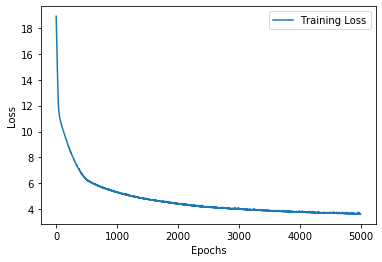

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
trained_model = model.fit(X_train, y_train, epochs=5000, callbacks=[callback])
loss_values = trained_model.history['loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
y_pred = model.predict(X_train)
y_pred

array([[44.914963],
       [46.38387 ],
       [21.354797],
       [21.930695],
       [29.429012],
       [20.542618],
       [47.210373],
       [20.463188],
       [56.471508],
       [50.20864 ],
       [43.65509 ],
       [61.306835],
       [23.002254],
       [16.243843],
       [22.400047],
       [20.409061],
       [22.063385],
       [21.597755],
       [19.05804 ],
       [29.282017],
       [17.00639 ],
       [27.451248],
       [45.699512],
       [33.706104],
       [52.594906],
       [24.290688],
       [47.98071 ],
       [56.053875],
       [17.709831],
       [52.79939 ],
       [41.764114],
       [18.333355],
       [49.5518  ],
       [29.093788],
       [16.904873],
       [20.618069],
       [34.99357 ],
       [19.30194 ],
       [25.67928 ],
       [20.827751],
       [22.84933 ],
       [21.301151],
       [20.630753],
       [20.861046],
       [21.89111 ],
       [21.74738 ],
       [34.915585],
       [47.57273 ],
       [18.475357],
       [55.1992  ],


In [14]:
print("{:.2f}".format((r2_score(y_train,y_pred))*100),"%")

83.45 %


In [15]:
mean_absolute_error(y_train,y_pred)

3.6346077285963916